
First, we prepare an environment by importing libraries:

In [4]:
import sys, os
import torch
import numpy as np
import matplotlib

from human_body_prior.tools.omni_tools import copy2cpu as c2c

# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

Second, we choose the device (gpu or cpu) to run the model on.


In [5]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The datasets that we downloaded in 2nd step - SMPL and DMPL, we will use these datasets in this section. Remember that we installed some repositories in the first step, find the folder human_body_prior-master go to>>go to human_body_prior>>body_model>>make two separate folders as simplh and dmpls here, copy and paste the SMPLH and DMPLs dataset in smplh and dmpls respectively.

Note: check the path in bm_path and dmpl_path carefully.

In [6]:
from human_body_prior.body_model.body_model import BodyModel

bm_path = './human_body_prior-master/human_body_prior/body_model/smplh/male/model.npz'
dmpl_path ='./human_body_prior-master/human_body_prior/body_model/dmpls/male/model.npz' 

num_betas = 10 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, num_dmpls=num_dmpls, path_dmpl=dmpl_path).to(comp_device)
faces = c2c(bm.f)

Now go to https://github.com/nghorbani/amass -Go to github_data, download amass_sample.npz. 

In this section, check the path of npz_bdata_path in first line.

In [7]:
npz_bdata_path = './human_body_prior-master/human_body_prior/amass_sample.npz' # the path to body data
bdata = np.load(npz_bdata_path)
print('Data keys available:%s'%list(bdata.keys()))
print('Vector poses has %d elements for each of %d frames.'%(bdata['poses'].shape[1], bdata['poses'].shape[0]))
print('Vector dmpls has %d elements for each of %d frames.'%(bdata['dmpls'].shape[1], bdata['dmpls'].shape[0]))
print('Vector trams has %d elements for each of %d frames.'%(bdata['trans'].shape[1], bdata['trans'].shape[0]))
print('Vector betas has %d elements constant for the whole sequence.'%bdata['betas'].shape[0])
print('The subject of the mocap sequence is %s.'%bdata['gender'])

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
Vector poses has 156 elements for each of 601 frames.
Vector dmpls has 8 elements for each of 601 frames.
Vector trams has 3 elements for each of 601 frames.
Vector betas has 16 elements constant for the whole sequence.
The subject of the mocap sequence is male.


In [8]:
fId = 0 # frame id of the mocap sequence

root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

In [9]:
print(root_orient)

tensor([[0.8873, 0.9125, 1.4135]])


In [11]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

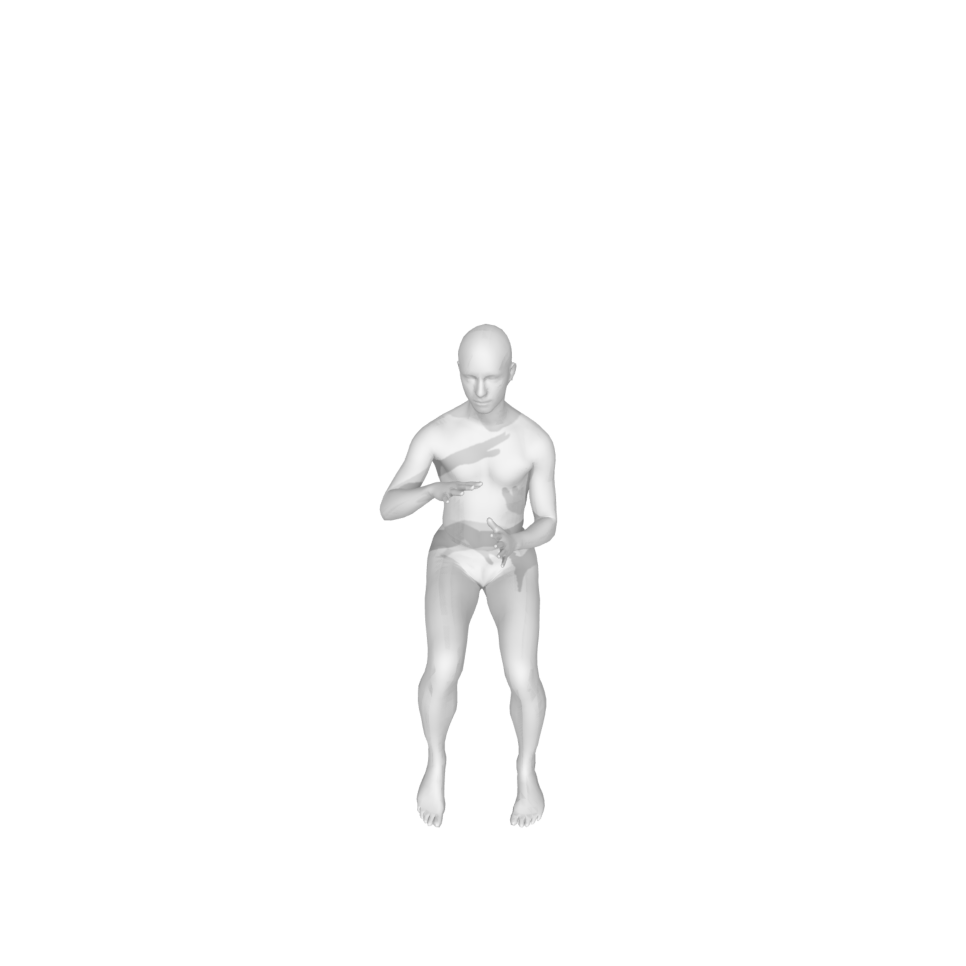

In [12]:
body = bm(pose_body=pose_body, betas=betas)
body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=False)
show_image(body_image)

This is how our body looks like using the pose and body shape parameters.The male subject is sitting and havig the hands open.

The skeletal structure of the human body is modeled with a kinematic chain consisting of rigid bone segments linked by joints. Each body joint has 3 rotational Degrees of Freedom (DoF), parametrized with exponential coordinates. The SMPL-H, adds hand articulation to the model using a total of n = 52 joints, where 22 joints are for the body and the remaining 30 joints belong to the hands[1]. Here SMPL-H is combined with DMPL to obtain a model that captures both hand pose and soft-tissue deformations.

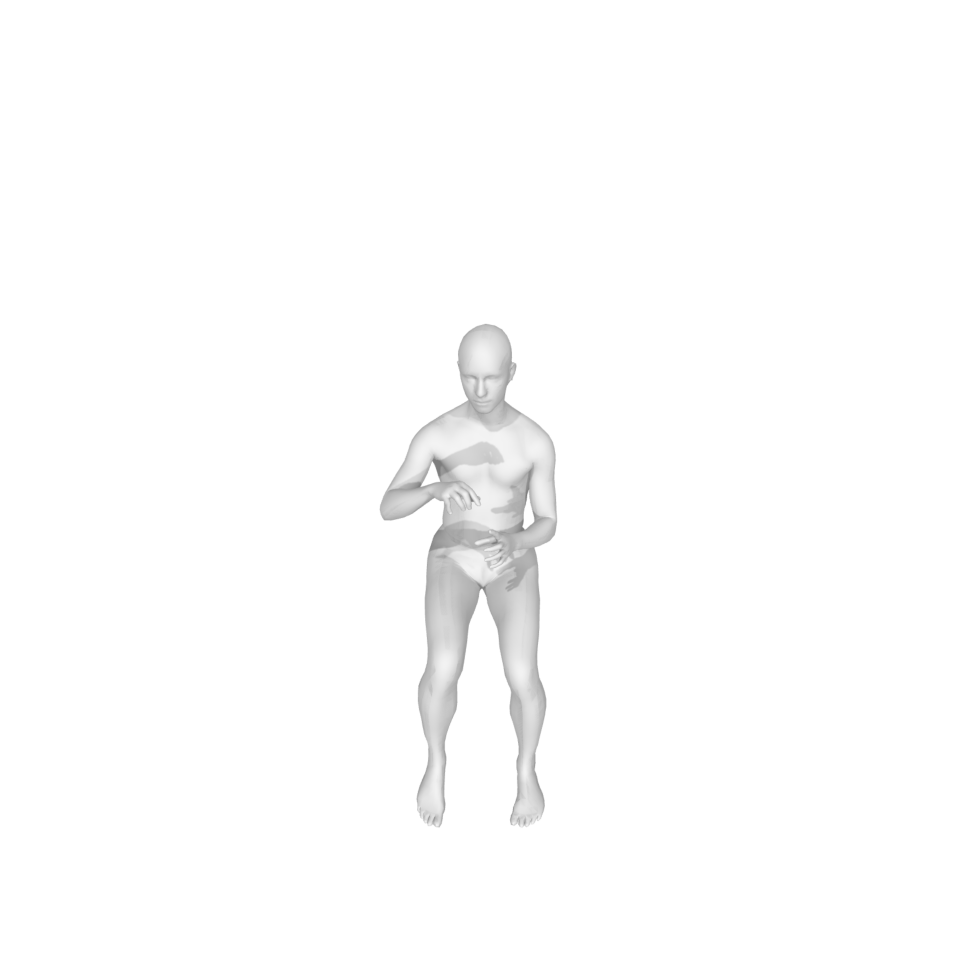

In [13]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wfingers])
body_image_wfingers = mv.render(render_wireframe=False)
show_image(body_image_wfingers)

In this step we visualize the hand poses by articulating the the finger. The fingers uses the 66:156 pose vector elements. We can compare this image with the above image. In the above image the hand of the male is open, whereas in this image the subject is holding something with one hand.

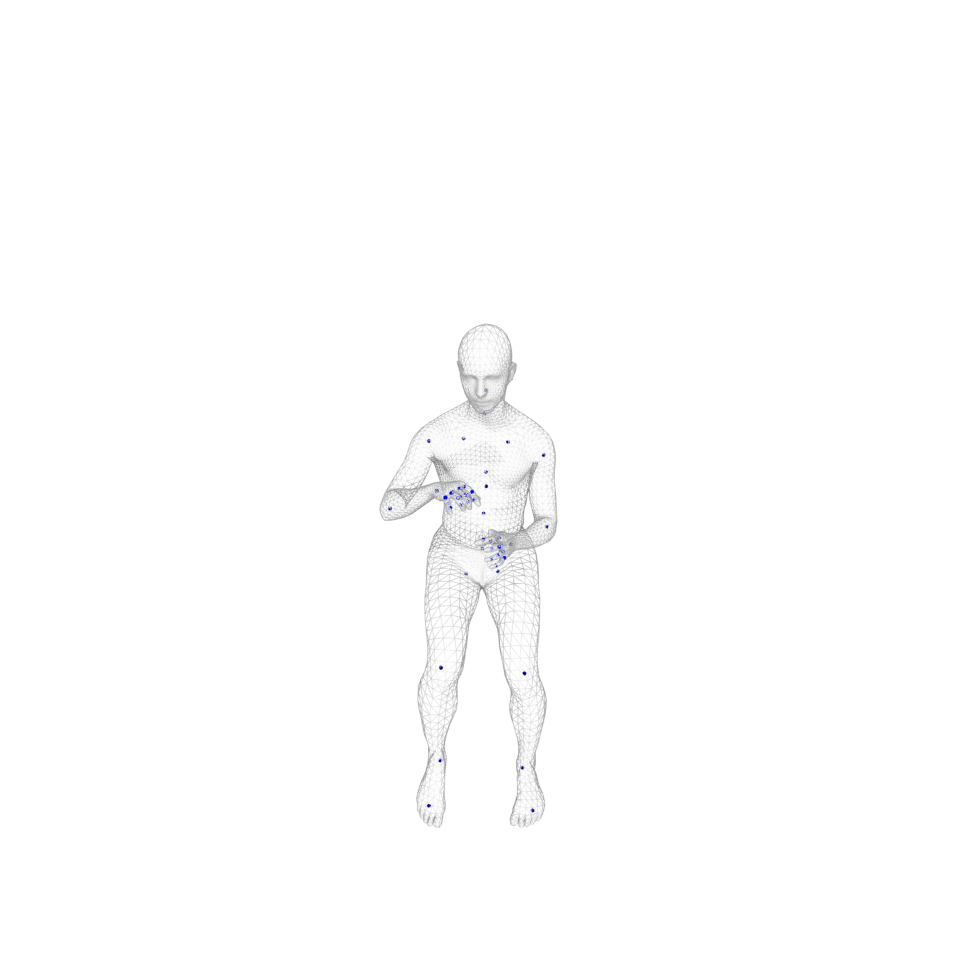

In [14]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
joints = c2c(body.Jtr[0])
joints_mesh = points_to_spheres(joints, vc = colors['red'], radius=0.005)
mv.set_static_meshes([body_mesh_wfingers] + joints_mesh)
body_image_wfingers_joints = mv.render(render_wireframe=True)
show_image(body_image_wfingers_joints)

In this section, we will visualize body joints. The body model has also joint locations. The joint location can be read by accesing Jtr attribute of the returned body and visualize them as spheres. Here we render the body transparently to visualize the joints. The blue points are the joint locations.

Visualization using DMPLs.



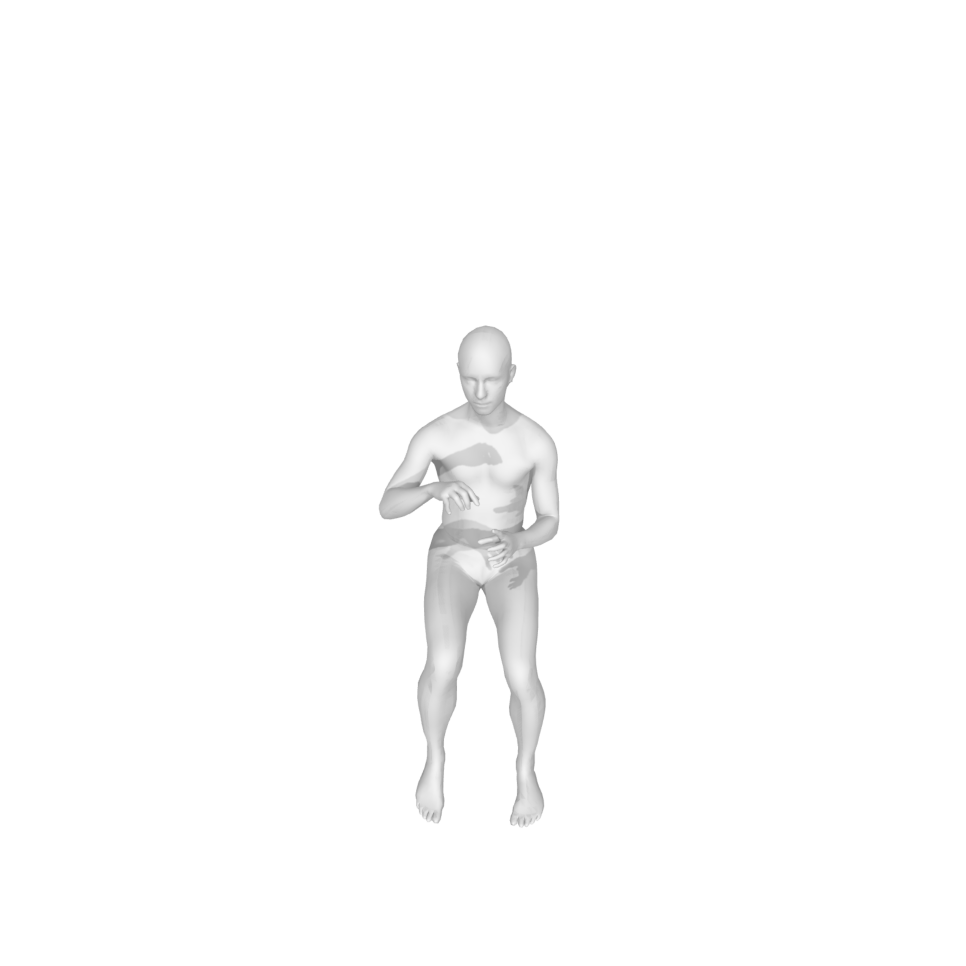

In [15]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls)
body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wdmpls])
body_image_wdmpls = mv.render(render_wireframe=False)
show_image(body_image_wdmpls)

We can also rotate the above body into different views. Below is the example for viewing he body into front view by transforming the mesh.We can globally control the character position and orientation with trans, and root_orient parameters respectively.

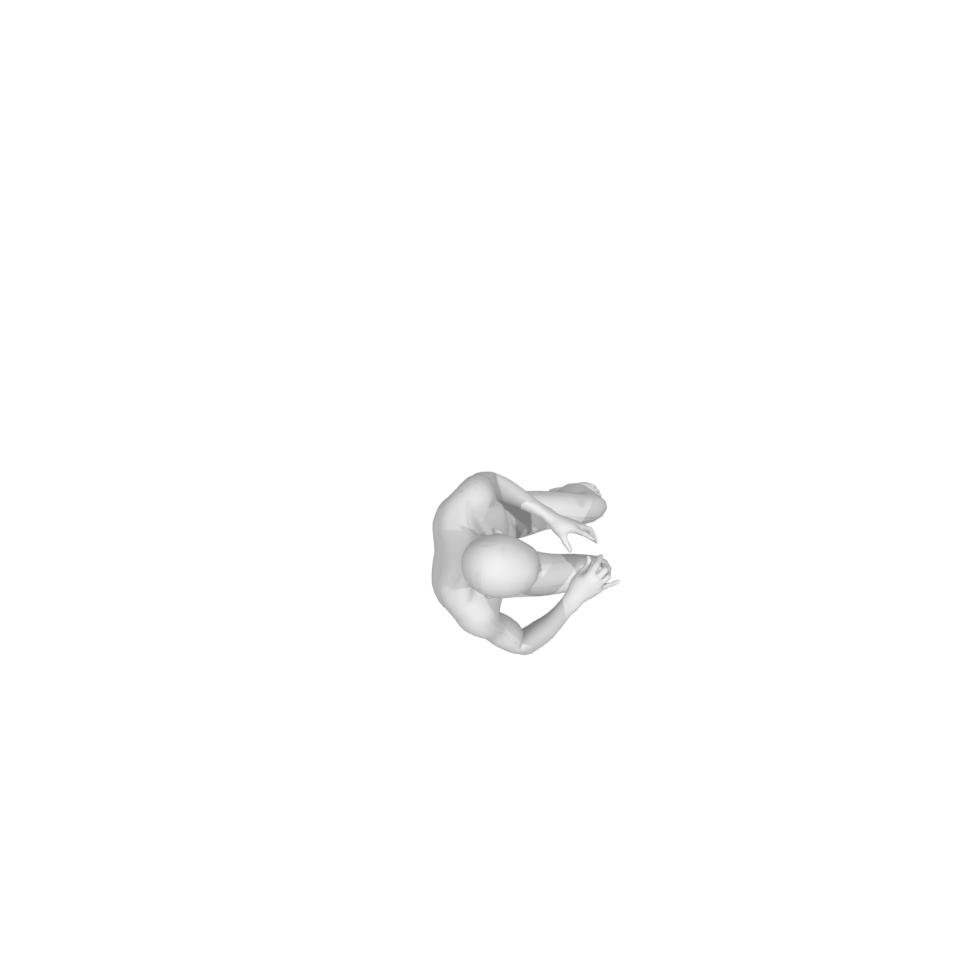

In [12]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)

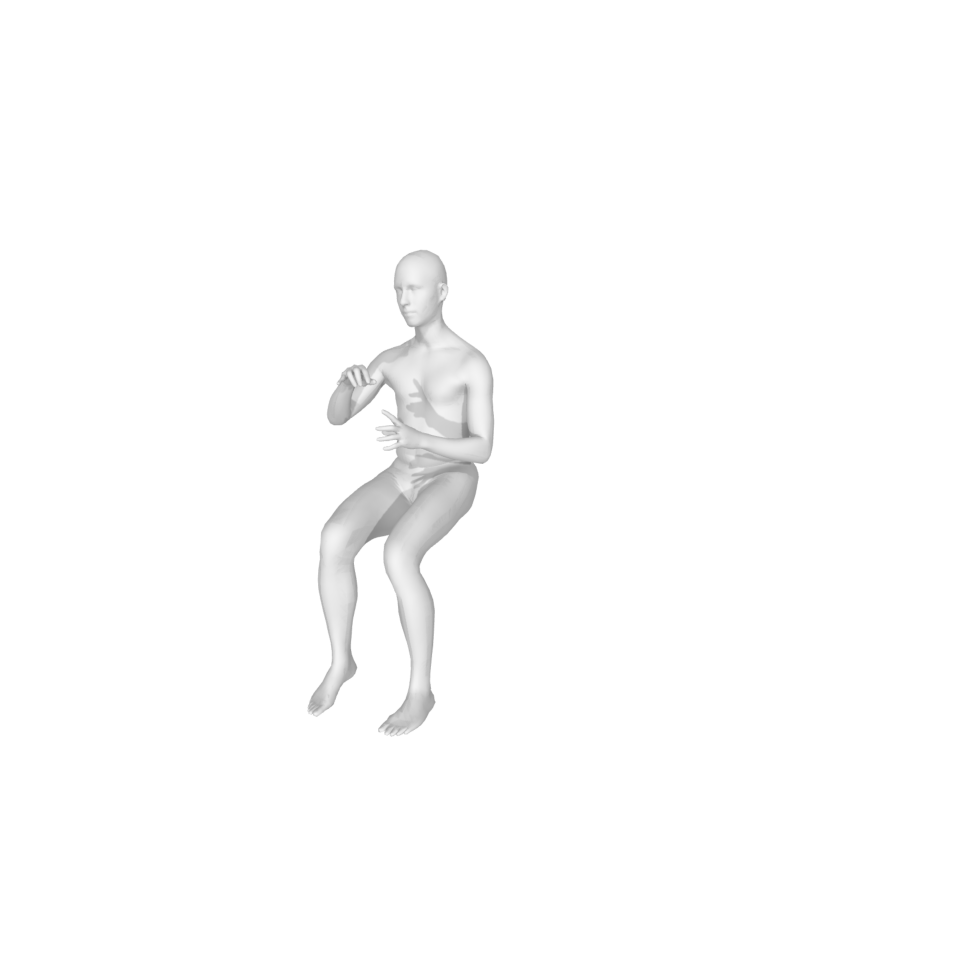

In [13]:
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(-90, (0, 0, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(30, (1, 0, 0)))

mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)

Note: This source code is taken from-